In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from validphys.api import API
from validphys.theorycovariance.higher_twist_functions import compute_deltas_pc

from ht_plot_utlis import plot_covmat_heatmap

In [2]:
fitname = "250310-ac-05-pc-low_cuts-ct-noBCDMS"
thcovmat_dict = API.fit(fit=fitname).as_input()["theorycovmatconfig"]
pc_parameters = thcovmat_dict['pc_parameters']
covmat_pdf = thcovmat_dict['pdf']
pc_included_prcs = thcovmat_dict['pc_included_procs']
pc_excluded_exps = thcovmat_dict['pc_excluded_exps']
fitpath = API.fit(fit=fitname).path

Construct the index used to label the parameters used to parameterise the higher twist

In [3]:
ht_names = []
ht_nodes = []
x_nodes = {}
beta_tilde = []
for pc_name, pc_par in pc_parameters.items():
  beta_tilde.append(pc_par['yshift'])
  x_nodes[pc_name] = pc_par['nodes']
  for idx_node in range(len(pc_par['yshift'])):
    ht_names.append(pc_name)
    ht_nodes.append(pc_name + f"({idx_node})")

ht_index_tuple = list(zip(ht_names, ht_nodes))
ht_index = pd.MultiIndex.from_tuples(ht_index_tuple, names=["HT", "nodes"])
beta_tilde = np.concatenate(beta_tilde)

In [4]:
save_dir = f"./Results/{fitname}"
target_dir = Path(save_dir)
pickle_path = Path(save_dir + "/posteriors.pkl")
if not target_dir.is_dir():
  target_dir.mkdir(parents=True, exist_ok=True)

In [5]:
common_dict = dict(
    dataset_inputs={"from_": "fit"},
    fit=fitname,
    fits=[fitname],
    use_cuts="fromfit",
    metadata_group="nnpdf31_process",
    theory={"from_": "fit"},
    theoryid={"from_": "theory"},
)

# Calculate theory predictions of the input PDF
S_dict = dict(
    theorycovmatconfig={"from_": "fit"},
    pdf={"from_": "theorycovmatconfig"},
    use_t0=True,
    datacuts={"from_": "fit"},
    t0pdfset={"from_": "datacuts"},
)

In [6]:
# Calculate theory predictions of the fit with ht covmat - this will be compared to data
preds = API.group_result_table_no_table(pdf={"from_": "fit"}, **common_dict)

LHAPDF 6.5.4 loading all 501 PDFs in set 250310-ac-05-pc-low_cuts-ct-noBCDMS
250310-ac-05-pc-low_cuts-ct-noBCDMS, version 1; 501 PDF members


In [7]:
preds_onlyreplicas = preds.iloc[:, 2:].to_numpy()
mean_prediction = np.mean(preds_onlyreplicas, axis=1)

In [8]:
# Experimental covariance matrix
C = API.groups_covmat_no_table(**common_dict)

### Load theory covmat

In [9]:
### Load power corrections covmat
S = pd.read_csv(
    fitpath / "tables/datacuts_theory_theorycovmatconfig_point_prescriptions0_theory_covmat_custom_per_prescription.csv",
    index_col=[0, 1, 2],
    header=[0, 1, 2],
    sep="\t|,",
    engine="python",
)
storedcovmat_index = pd.MultiIndex.from_tuples(
    [(aa, bb, np.int64(cc)) for aa, bb, cc in S.index],
    names=["group", "dataset", "id"],
)
S = pd.DataFrame(
    S.values, index=storedcovmat_index, columns=storedcovmat_index
)
S = S.reindex(C.index).T.reindex(C.index)

In [10]:
### Load MHO covmat, if present
try:
  S_scale_var = pd.read_csv(
      fitpath / "tables/datacuts_theory_theorycovmatconfig_point_prescriptions1_theory_covmat_custom_per_prescription.csv",
      index_col=[0, 1, 2],
      header=[0, 1, 2],
      sep="\t|,",
      engine="python",
  )
  storedcovmat_index = pd.MultiIndex.from_tuples(
      [(aa, bb, np.int64(cc)) for aa, bb, cc in S_scale_var.index],
      names=["group", "dataset", "id"],
  )
  S_scale_var = pd.DataFrame(
      S_scale_var.values, index=storedcovmat_index, columns=storedcovmat_index
  )

  S_scale_var = S_scale_var.reindex(C.index).T.reindex(C.index)
  C = C + S_scale_var
except FileNotFoundError:
  print('No scale variations')

No scale variations


### Construct beta

In [11]:
groups_data_by_process = API.groups_data_by_process(**common_dict)
pdf = API.pdf(pdf=covmat_pdf)
shifts = {}
for group_proc in groups_data_by_process:
    for exp_set in group_proc.datasets:
        if exp_set.name not in pc_excluded_exps and group_proc.name in pc_included_prcs:
          shifts[exp_set.name] = compute_deltas_pc(exp_set, pdf, pc_parameters, 'linear')

LHAPDF 6.5.4 loading /opt/homebrew/Caskroom/miniconda/base/envs/nnpdf/share/LHAPDF/240701-02-rs-nnpdf40-baseline/240701-02-rs-nnpdf40-baseline_0000.dat
240701-02-rs-nnpdf40-baseline PDF set, member #0, version 1


In [12]:
# Construct the dataframe
col_index = ht_index.droplevel('HT')
col_index.name = 'shifts'
row_index = C.index
beta = pd.DataFrame(np.zeros(shape=(row_index.size, col_index.size)), index=row_index, columns=col_index)
beta = beta.droplevel('group')

for exp_name in shifts.keys():
  for combs_name in shifts[exp_name].keys():
    beta.loc[(exp_name), combs_name] = shifts[exp_name][combs_name]

Test if loaded $\beta$'s reconstruct the stored theory covmat

In [13]:
S_test = np.zeros((beta.shape[0], beta.shape[0]))
for shift in beta.columns:
    S_test += np.outer(beta[shift].to_numpy(), beta[shift].to_numpy())

S_test = pd.DataFrame(S_test, columns=beta.index, index=beta.index)
assert(np.allclose(S.to_numpy(), S_test.to_numpy()))

Sum theory and experimental covmat and invert

In [14]:
invcov = np.linalg.inv(C + S)

Define the DataFrame containing the central values of the prior for each parameter.

In [15]:
central_ht_coeffs = pd.DataFrame(np.zeros(ht_index.shape), index=ht_index, columns=['central'])

### Collect central data

In [16]:
pseudodata = API.read_pdf_pseudodata(**common_dict)
dat_central = np.mean(
    [i.pseudodata.reindex(preds.index.to_list()).to_numpy().flatten() for i in pseudodata],
    axis=0,
)

# Compute the posterior
-----------------------

This section implements the equations presented in arXiv:2105.05114.

We first need to compute the shift for the "genuine" predictions. These are theoretical predictions for quantities that are not constrained from the fit. These could be predictions for datasets that were not included in the fit, or predictions for model parameters. In the case of power corrections, the the genuine predictions are the size of the shift in predictions introduced by the power correction it self. Hence, taking into account the theoretical uncertainty, these predictions can be written as below
$$
\tilde{T}(\tilde{\lambda}) = \tilde{T} + \tilde{\lambda} \tilde{\beta},
$$
where $\tilde{\lambda}$ is the nuisance parameter that models the theoretical uncertainty of the genuine prediction, and the vector $\tilde{\beta}$ is the size and direction of the theoretical uncertainty. Note that $\tilde{T}$ represents the prior, which in our case is zero (no information on power corrections beforehand).

In principle the theoretical uncertainty for the genuine predictions (*i.e.* $\tilde {\lambda}$) might be correlated to the that of the observables $T_i$. If that is not the case, $\lambda$ and $\tilde{\lambda}$ are independent and theoretical uncertainties in $\tilde{T}$ are __uncorrelated__ with those in $\tilde{T}$. The theory covariance matrix for the genuine prediction is then
$$
\tilde{S} = \tilde{\beta} \tilde{\beta}^T .
$$
If they are correlated, $\tilde{\lambda} = \lambda$ and we can infer the posterior for the shift in the genuine predictions,
$$
\mathbb{E} [\tilde{T}(\lambda)] = \tilde{T} + \lambda(T,D) \tilde{\beta} \,,
$$
by taking advantage of the information from the data $D$ and the observables $T$. Specifically (see paper for details), the shift is
$$
\delta \tilde{T} = - \hat{S}(C+S)^{-1} (T_0 - D) \,,
$$
where 
$$
\hat{S} = \tilde{\beta} \beta^T \,,
$$
represents the cross-correlations between observables and genuine predictions.

The vector $\tilde{\beta}$ is the size and direction of the theoretical uncertainty. By "direction" here we mean the physical source of uncertainty that is encoded in the fit. For instance, if the fit relies on two parameters (__e.g.__ $\alpha_s$ and $m_t$), than
the direction of the theoretical uncertainty lives in the two-dimensional vector space spanned by these two parameters. The choice of this directions is, of course, arbitrary and should be addressed through a case-by-case study.


### Multiple nuisance parameters
In the previous discussion we have assumed only one uncertainty of correlated theoretical uncertainty, which is described by the __vector__ $\beta$ or $\tilde{\beta}$. This means that both $S$ and $\tilde{S}$ will have one non-zero eigenvalue by construction. However, choosing only one direction in the theoretical uncertainty can be limiting as in principle any direction is equivalent. In order to span different directions and provide a more balance contribution, different shifts might be considered. Each shift will be then regarded as a "source" of theoretical uncertainty and these will be labelled as $\beta_{\alpha}$ and $\tilde{\beta}_{\alpha}$. Note the construction of the theory covariance matrices becomes
$$
S = \beta_{\alpha} \beta_{\alpha}^T \hspace{5mm} \textrm{and} \hspace{5mm}
\tilde{S} = \tilde{\beta}_{\alpha} \tilde{\beta}^T \,.
$$
Note that now, by construction, the theoretical covariance matrices can have many non-zero eigenvalues. Considering the example introduced before, we might consider two directions in the two-dimensional vector space spanned by the two parameters. For instance, we could use the combinations $(\bar{p}_1,0)$ and $(0, \bar{p}_2)$ to compute the two directions. In general, the choice of these combinations of directions specifies the __prescription__.

### The case of power corrections
In the present case, power corrections are modelled as shifts on a bin-by-bin basis. Moreover, different power corrections are introduced depending on the target (proton and deuteron), the process (jets or DIS), and observables ($F_2$ or $\sigma$).

The parameters correspond to the shifts in each kinematic bin. The prior defines the size of the shifts in each bin. These shifts are then combined together according to a certain prescription. In this case, we use a "generalized" 5-point prescription, where each bin is varied one at the time. For instance, if we have 7 bins, then 7 different directions are constructed. This argument is applied to all the parameters for the power corrections.

The shifts $\tilde{\beta}$ are computed below

In [17]:
# Compute beta_tilde according to the 5pt prescription
tmp_mat = np.zeros(shape=(len(beta_tilde), len(beta_tilde)))
np.fill_diagonal(tmp_mat, beta_tilde)
beta_tilde = pd.DataFrame(tmp_mat, index=ht_index, columns=ht_index)

Here we compute $\tilde{S}$
$$
\tilde{S} = \tilde{\beta}_{\alpha} \tilde{\beta}_{\alpha}^T
$$

In [18]:
S_tilde = np.zeros(beta_tilde.shape)
for shift in beta_tilde.columns:
    S_tilde += np.outer(beta_tilde[shift], beta_tilde[shift])
S_tilde = pd.DataFrame(S_tilde, index=beta_tilde.index, columns=beta_tilde.columns)

and $\hat{S}$
$$
\hat{S} = \beta \tilde{\beta}^T
$$

In [19]:
S_hat = np.zeros((beta_tilde.shape[0], beta.shape[0]))
for shift in beta.columns:
    S_hat += np.outer(beta_tilde.droplevel(level="HT", axis=1)[shift], beta[shift])
S_hat = pd.DataFrame(S_hat, index=beta_tilde.index, columns=beta.index)

Then we compute the matrix $X$ defined as
$$
X = \left< (T^{(r)} - T_0)(T^{(r)} - T_0)^T \right> .
$$
This represents the "fitting uncertainty", namely the uncertainty of the predictions $T$.

In [20]:
X = np.zeros((mean_prediction.shape[0], mean_prediction.shape[0]))
for i in range(preds_onlyreplicas.shape[1]):
    X += np.outer(
        (preds_onlyreplicas[:, i] - mean_prediction),
        (preds_onlyreplicas[:, i] - mean_prediction),
    )
X *= 1 / preds_onlyreplicas.shape[1]

We now compute $\delta \tilde{T}$
$$
\delta \tilde{T} = - \hat{S}(C+S)^{-1} (T_0 - D) \,,
$$
and then the posterior is
$$
\tilde{T} = \tilde{T}_0 + \delta \tilde{T}
$$

In [21]:
delta_T_tilde = -S_hat @ invcov @ (mean_prediction - dat_central)
posteriors = central_ht_coeffs['central'] + delta_T_tilde

Finally, compute the shift for the genuine predictions and the covariance matrix $\tilde{P}$
$$
\tilde{P} = \hat{S} (C+S)^{-1} X (C + S)^{-1} \hat{S}^T + (\tilde{S} - \hat{S}(C+S)^{-1}\hat{S}^T) \,.
$$
Note that some contributions are neglected in the equation above as they are identically zero in this case. The full expression is shown in eq. (3.38) of the paper.

In [22]:
invcov = pd.DataFrame(invcov, columns=S_hat.columns, index=S_hat.columns)
X = pd.DataFrame(X, columns=S_hat.columns, index=S_hat.columns)
P_tilde = S_hat @ invcov @ X @ invcov @ S_hat.T + (S_tilde - S_hat @ invcov @ S_hat.T)

In [23]:
#Save to pickle
pd.to_pickle(posteriors, save_dir + '/posteriors.pkl')
pd.to_pickle(P_tilde, save_dir + '/P_tilde.pkl')

# Representation of the posterior
---------------------------------

First, we plot the correlations between the inferred parameters

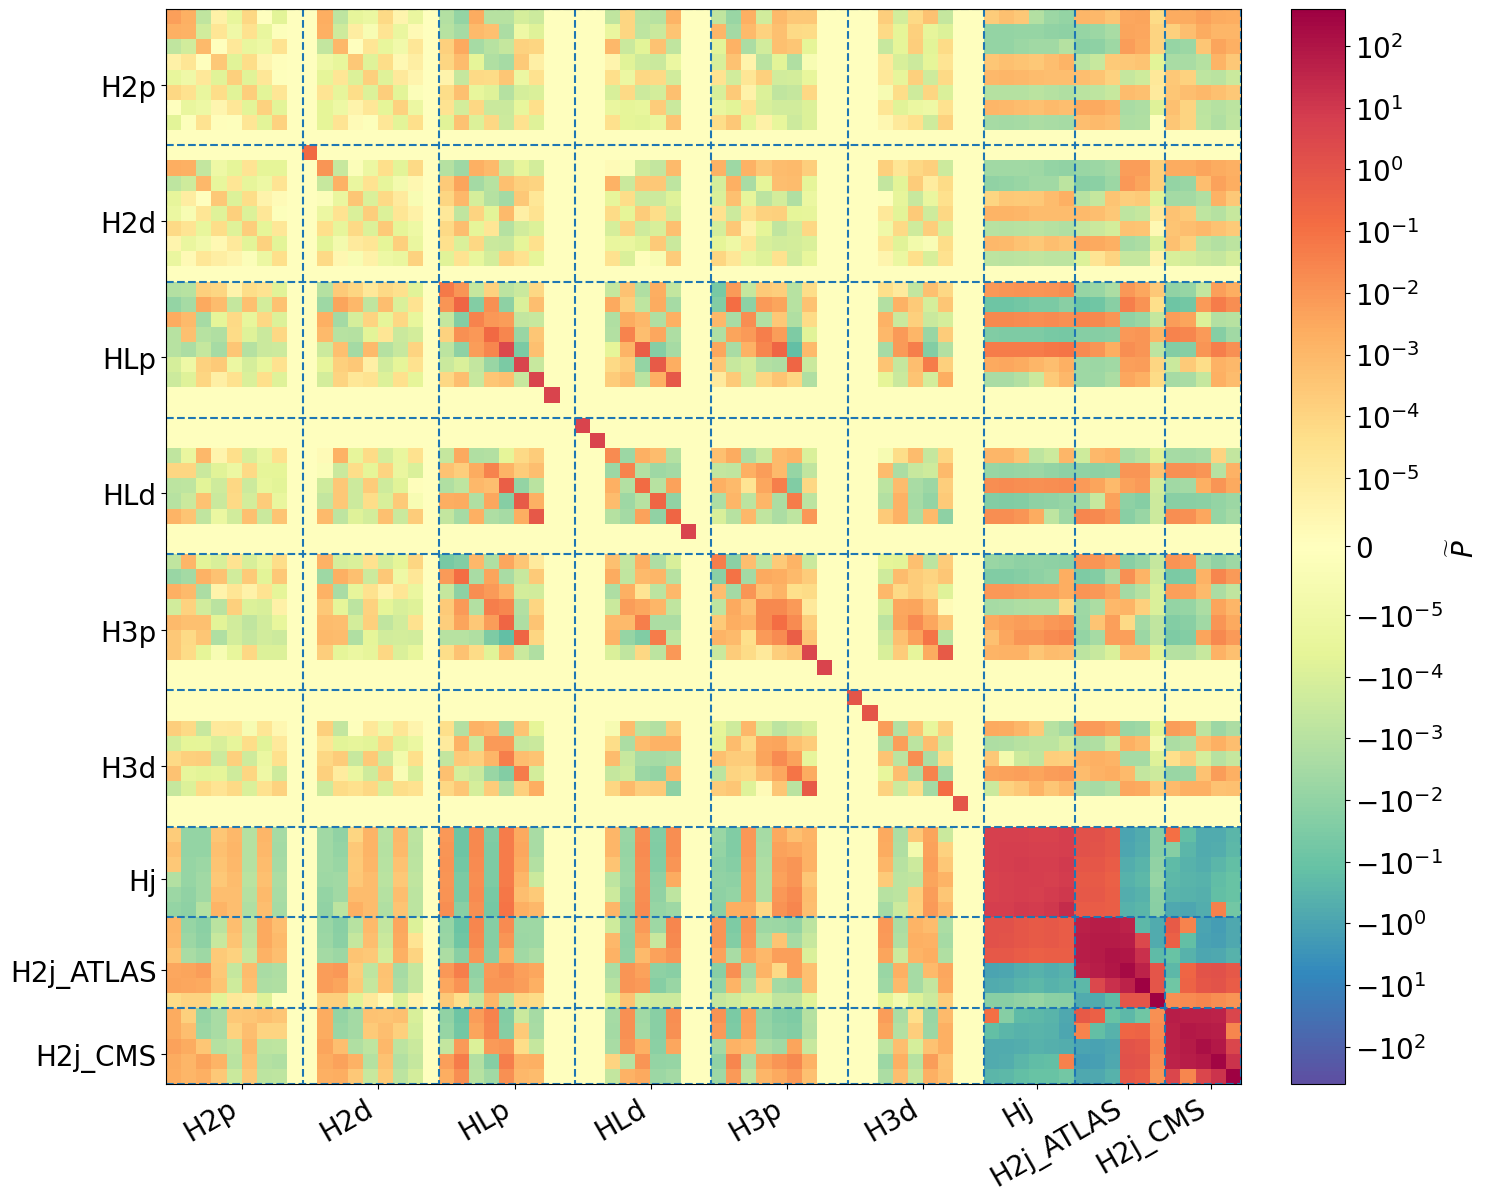

In [24]:
fig_matmap = plot_covmat_heatmap(P_tilde, "")

fig_matmap.tight_layout()
fig_matmap.savefig(save_dir + '/heatmap.png')

Then, we plot the posteriors as done in the construction of the prior.

In [26]:
def fluctuate_points_cholesky(mat, central_data, replicas=1, seed=1):
  fluctuate_points = np.zeros((central_data.size, replicas))

  # Remove zero columns and rows
  non_zero_columns = np.any(mat != 0, axis=0)
  covmat = mat[:, non_zero_columns]
  non_zero_rows = np.any(covmat != 0, axis=1)
  covmat = covmat[non_zero_rows, :]
  
  # Apply the same mask to central data
  data = central_data[non_zero_rows]

  # Compute Cholesky decomposition
  L = np.linalg.cholesky(covmat)

  # Loop over replicas
  for k in range(replicas):
    rng = np.random.default_rng(seed=seed + k)
    noise = L @ rng.normal(size=data.size)
    fluctuate_points[:, k] = central_data
    fluctuate_points[non_zero_rows, k] += noise

  return fluctuate_points

Text(0, 0.5, 'Average of pseudodata')

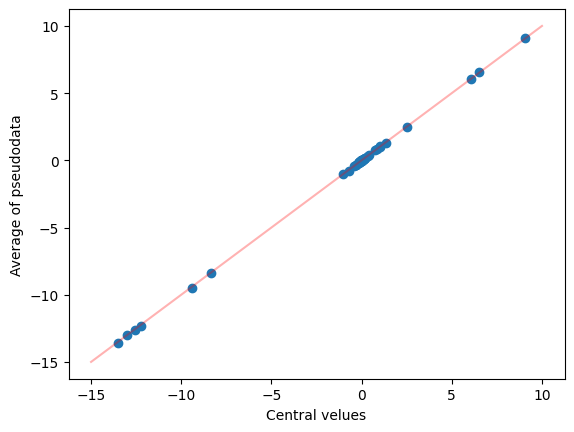

In [104]:
replicas = fluctuate_points_cholesky(P_tilde.to_numpy(), posteriors.to_numpy(), replicas=10000, seed=2143123)
mean = pd.Series(replicas.mean(axis=1), index=posteriors.index)
std = pd.Series(replicas.std(axis=1), index=posteriors.index)
df_replicas = pd.DataFrame(replicas, index=posteriors.index, columns=[f"replica_{i}" for i in range(replicas.shape[1])])

# Plot pseudo points against real data
x = np.linspace(-15, 10, 100)
plt.scatter(posteriors.to_numpy(), mean.to_numpy())
plt.plot(x, x, color="red", ls="-", alpha=0.3)
plt.xlabel("Central velues")
plt.ylabel("Average of pseudodata")

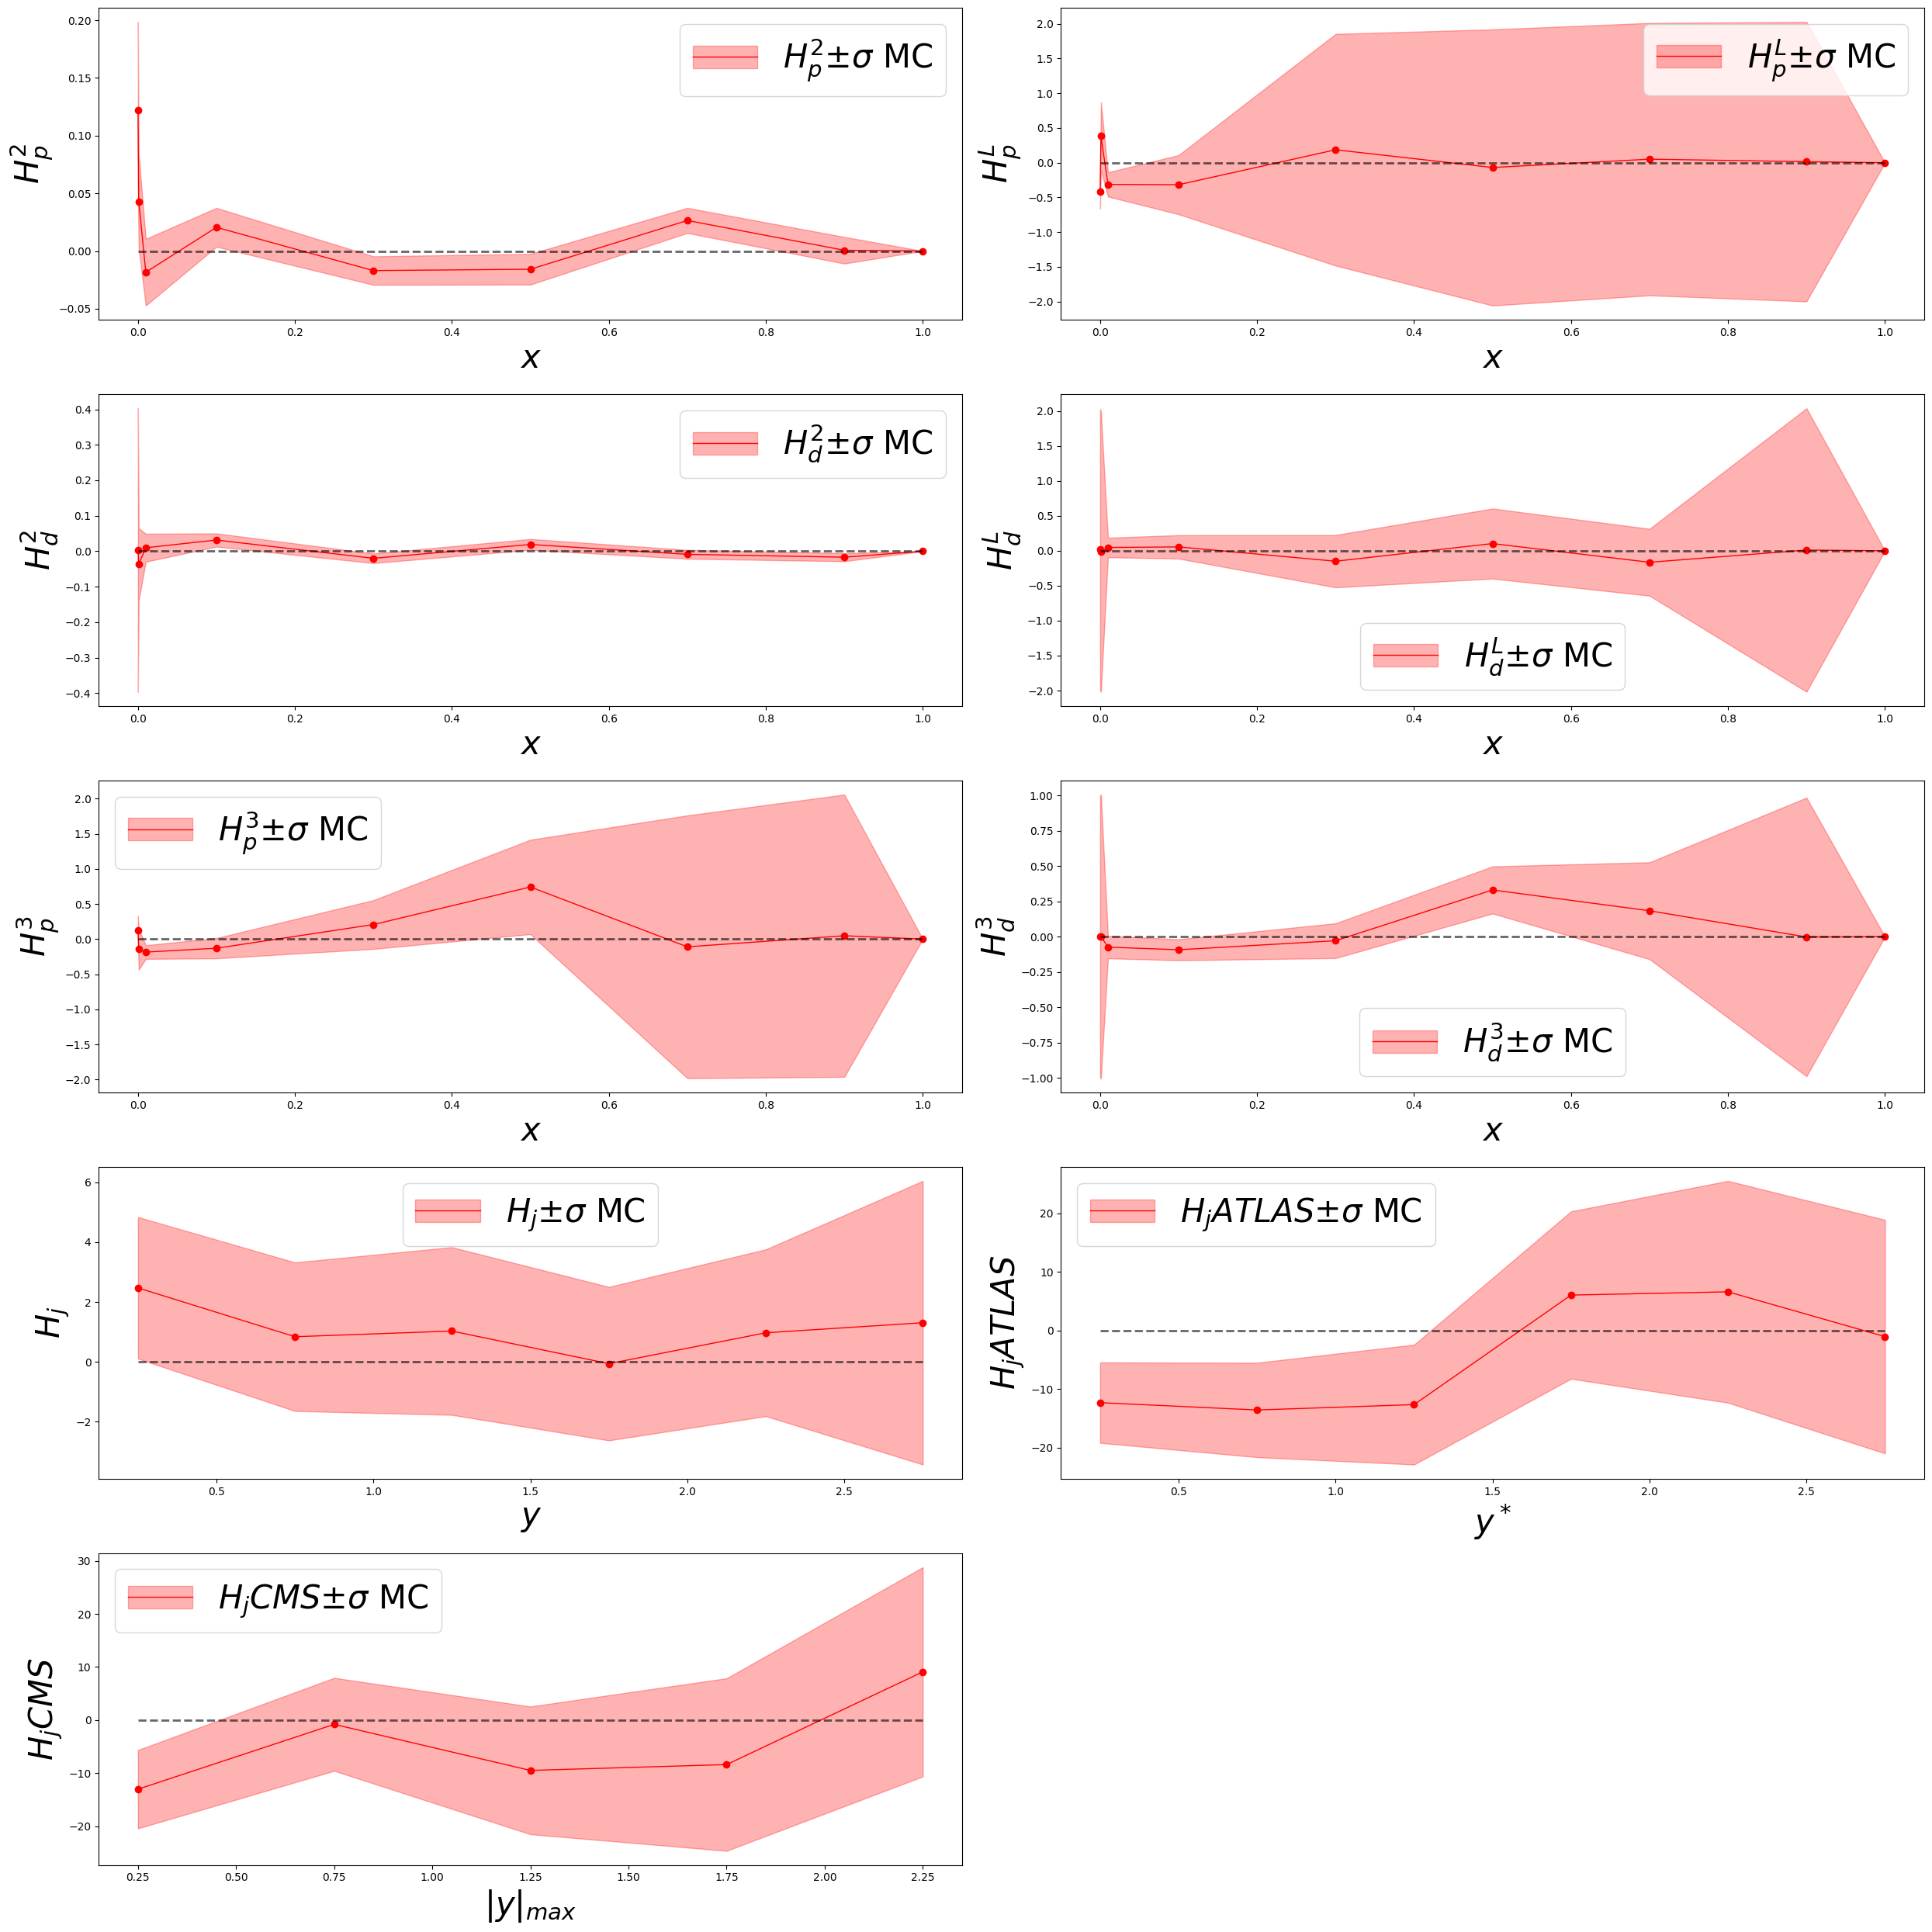

In [106]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(25, 25))
color = "red"
keys = ["H2p", "HLp", "H2d", "HLd", "H3p", "H3d", "Hj", "H2j_ATLAS", "H2j_CMS"]
axs[4,1].axis('off')

for idx_ax, (ax, key) in enumerate(zip(axs.flatten(), keys)):
  xaxis = x_nodes[key]

  # Extract central shift and std for the shift
  # shift_central = posteriors.xs(level='HT', key=key).to_numpy()
  # shift_std = np.sqrt(P_tilde.xs(level='HT', key=key).T.xs(level='HT', key=key).to_numpy().diagonal())

  shift_central = mean.xs(level='HT', key=key).to_numpy()
  shift_std = std.xs(level='HT', key=key).to_numpy()
  
  # Choose the x label according to the key
  if len(key) == 3:
    ylabel = rf"$H^{key[1]}_{key[2]}$"
    xlabel = f"$x$"
  else:
    if key == "H2j_ATLAS":
      ylabel = f"$H_j ATLAS$"
      xlabel = f"$y^*$"
    elif key == "H2j_CMS":
      xlabel = f"$|y|_{{max}}$"
      ylabel = rf"$H_j CMS$"
    else:
      xlabel = f"$y$"
      ylabel = rf"$H_j$"
  
  # Compute y values and std for the shift
  pl = ax.plot(xaxis, shift_central, ls = "-", lw = 1, color = color)
  ax.scatter(xaxis, shift_central, color = color)
  pl_lg = ax.fill(np.NaN, np.NaN, alpha = 0.3, color = pl[0].get_color()) # Necessary for fancy legend
  pl_fb  = ax.fill_between(xaxis, shift_central - shift_std, shift_central + shift_std, color = pl[0].get_color(),  alpha = 0.3)

  # Zero line
  ax.plot(xaxis, np.zeros_like(xaxis), ls = "dashed", lw = 2, color="black", alpha=0.6)
  ax.set_xlabel(xlabel, fontsize = 30)

  ax.set_ylabel(ylabel, fontsize = 30)
  label = ylabel + rf"$\pm \sigma$ MC"
  ax.legend([(pl[0], pl_lg[0])], [label], loc='best', fontsize=30)
  ax.set_xscale('log')
  
  fig.tight_layout()
  fig.savefig(save_dir + "/log_scale.png")

for ax in axs.flatten():
 ax.set_xscale('linear')

fig.tight_layout()
fig.savefig(save_dir + "/linear_scale.png")

# Plot using `PchipInterpolator`

In [107]:
from scipy import interpolate as scint
from collections import defaultdict
x_grid = np.logspace(-3, -0.0001, 2000)
rap_grid = np.linspace(0.0, 3, 2000)

def generate_replicas(df_replicas, x_nodes):
  fn_replicas_dict = defaultdict(dict)

  for pc_type in df_replicas.droplevel(level='nodes', axis=0).index.unique():
    xgrid = rap_grid if "j" in pc_type else x_grid
    shifts = df_replicas.xs(level='HT', key=pc_type).to_numpy()
    nodes = x_nodes[pc_type]
    aux = np.zeros((xgrid.size, shifts.shape[1]))

    for k in range(df_replicas.shape[1]):
      spline = scint.PchipInterpolator(nodes, shifts[: ,k])
      aux[:, k] = spline(xgrid)
    
    fn_replicas_dict[pc_type] = aux
  
  return fn_replicas_dict

fn_replicas_dict = generate_replicas(df_replicas, x_nodes)

(-25.0, 30.0)

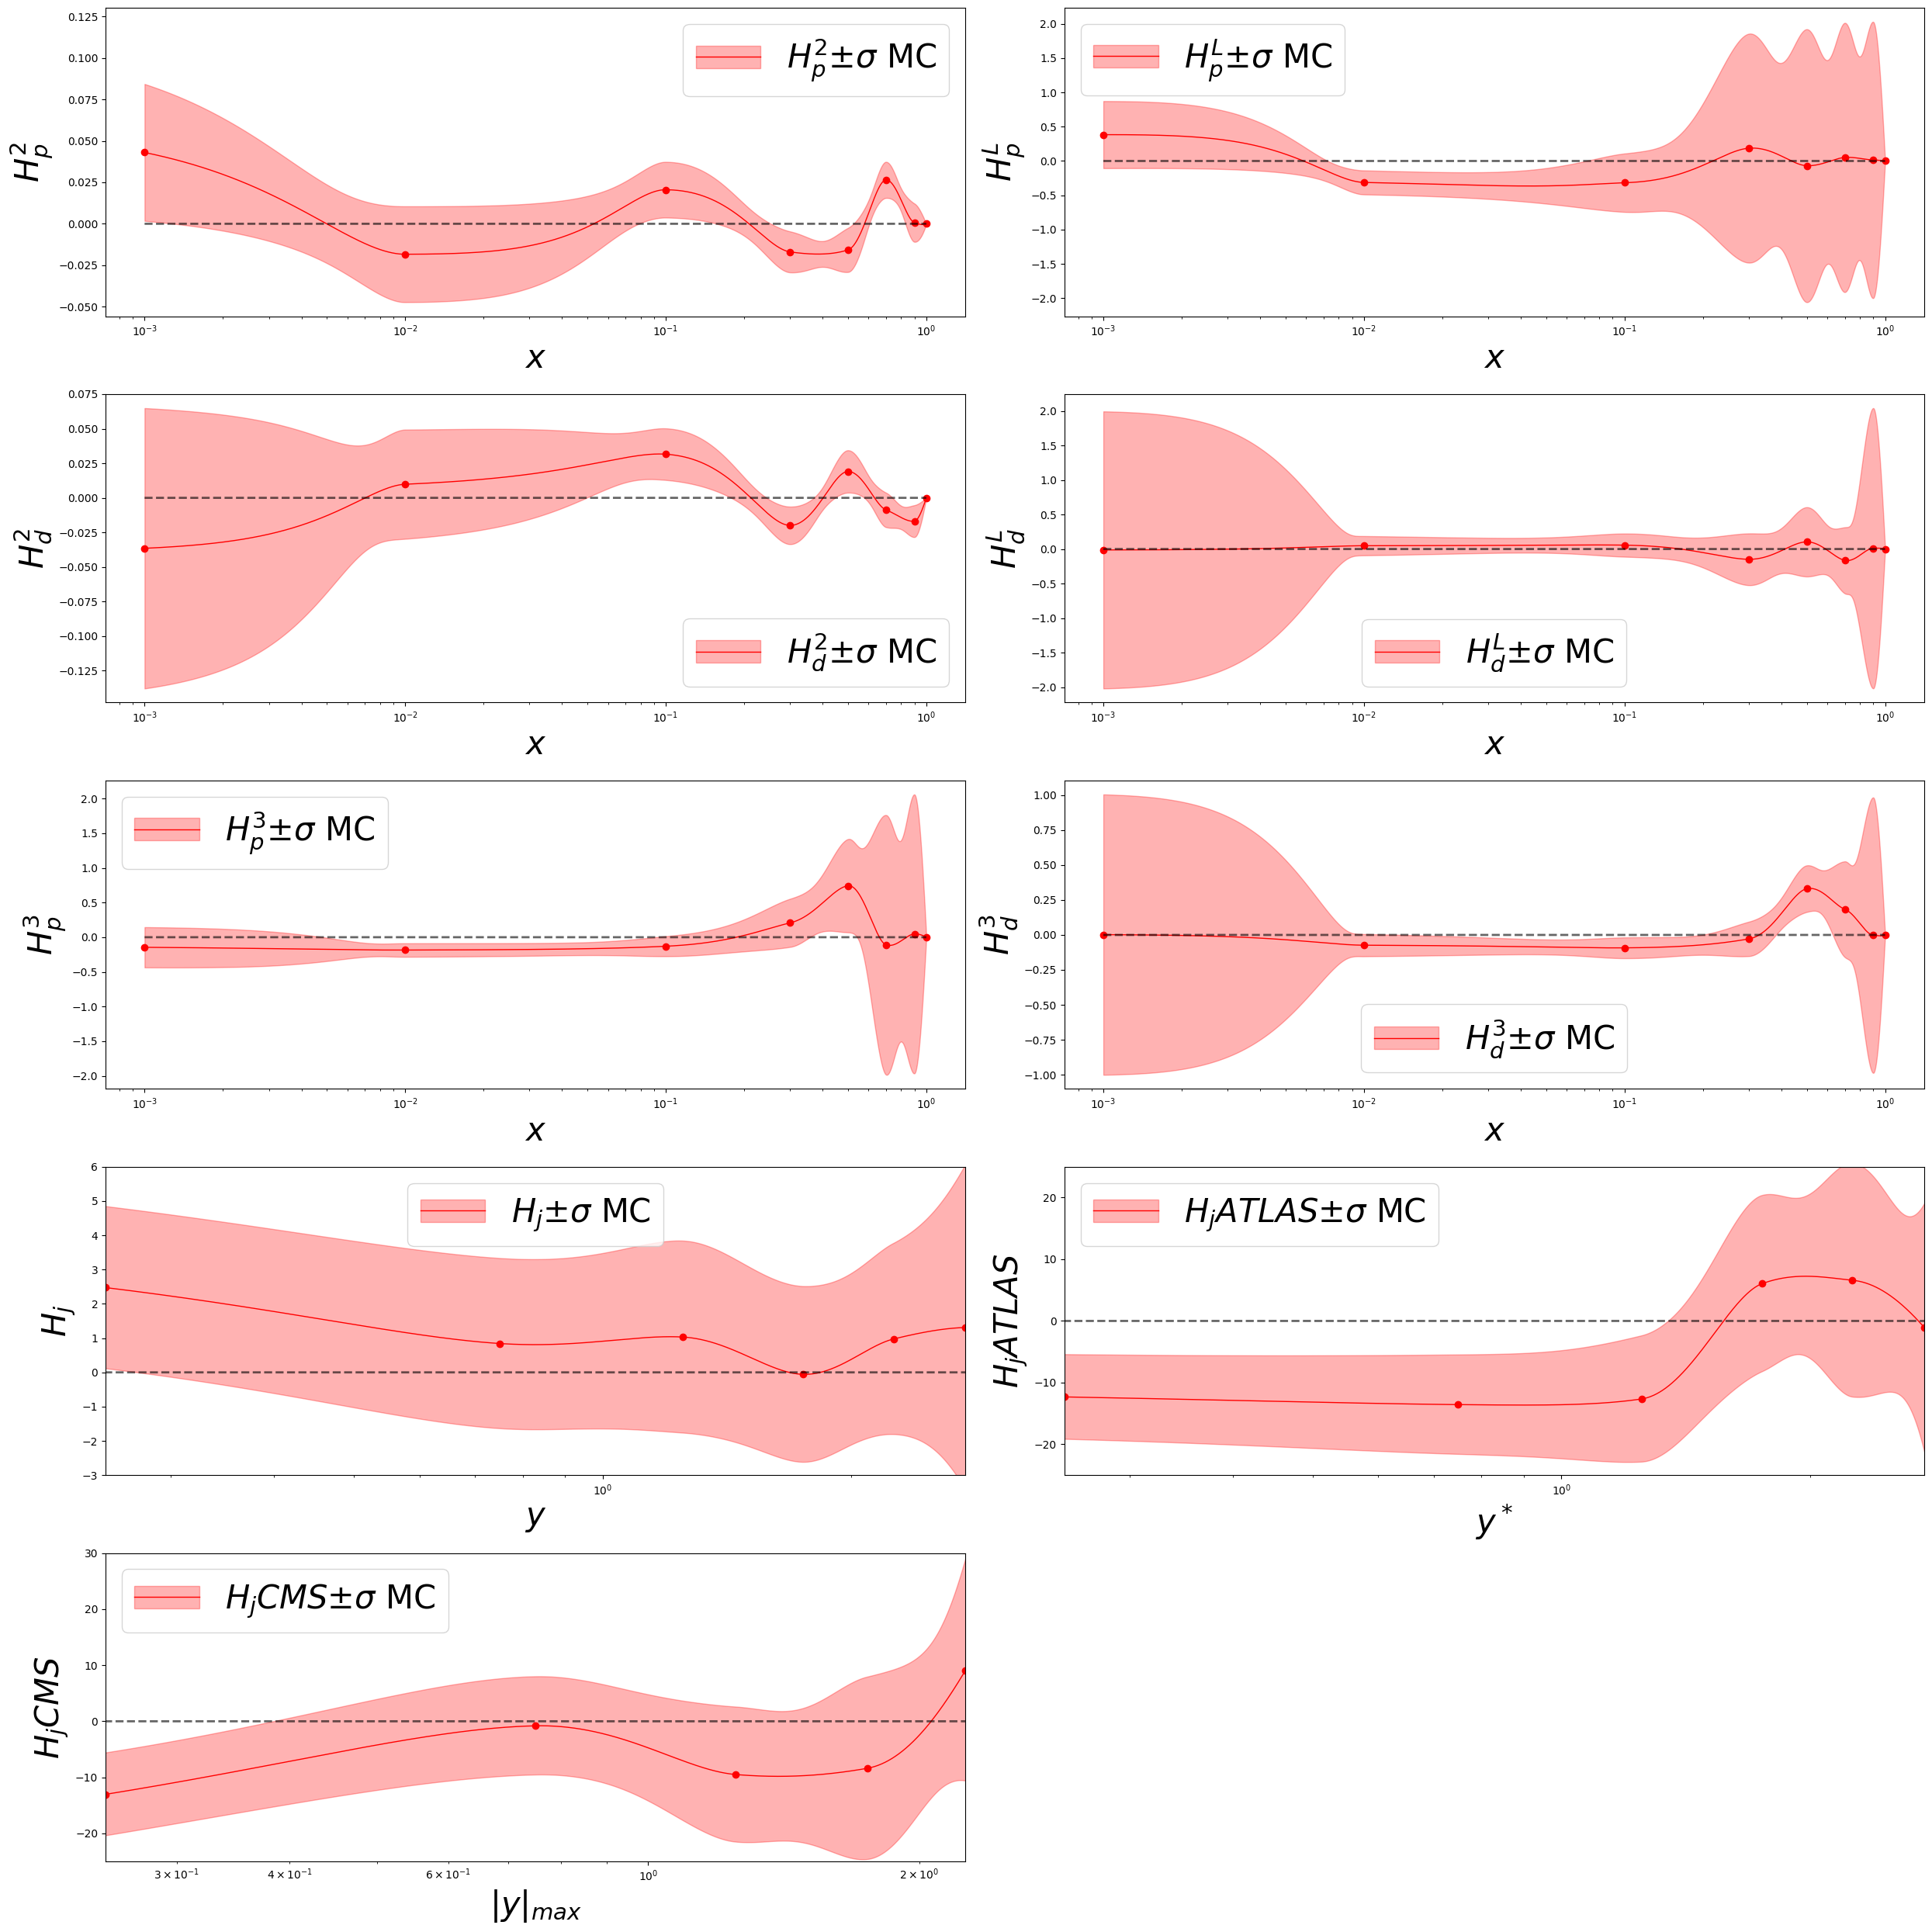

In [119]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(25, 25))
color = "red"
keys = ["H2p", "HLp", "H2d", "HLd", "H3p", "H3d", "Hj", "H2j_ATLAS", "H2j_CMS"]
axs[4,1].axis('off')

for idx_ax, (ax, key) in enumerate(zip(axs.flatten(), keys)):
  xaxis = rap_grid if "j" in key else x_grid
  replicas = fn_replicas_dict[key]
  central = replicas.mean(axis=1)
  std = replicas.std(axis=1)

  shift_central = mean.xs(level='HT', key=key).to_numpy()
  #shift_std = std.xs(level='HT', key=key).to_numpy()
  
  # Choose the x label according to the key
  if len(key) == 3:
    ylabel = rf"$H^{key[1]}_{key[2]}$"
    xlabel = f"$x$"
  else:
    if key == "H2j_ATLAS":
      ylabel = f"$H_j ATLAS$"
      xlabel = f"$y^*$"
    elif key == "H2j_CMS":
      xlabel = f"$|y|_{{max}}$"
      ylabel = rf"$H_j CMS$"
    else:
      xlabel = f"$y$"
      ylabel = rf"$H_j$"
  
  # Compute y values and std for the shift
  pl = ax.plot(xaxis, central, ls = "-", lw = 1, color = color)
  pl_lg = ax.fill(np.NaN, np.NaN, alpha = 0.3, color = pl[0].get_color()) # Necessary for fancy legend
  ax.scatter(x_nodes[key], shift_central, color = color)
  pl_fb  = ax.fill_between(xaxis, central - std, central + std, color = pl[0].get_color(),  alpha = 0.3)

  # Zero line
  ax.plot(xaxis, np.zeros_like(xaxis), ls = "dashed", lw = 2, color="black", alpha=0.6)
  ax.set_xlabel(xlabel, fontsize = 30)

  ax.set_ylabel(ylabel, fontsize = 30)
  label = ylabel + rf"$\pm \sigma$ MC"
  ax.legend([(pl[0], pl_lg[0])], [label], loc='best', fontsize=30)
  ax.set_xscale('log')
  
  fig.tight_layout()

axs[3,0].set_xlim(0.25,2.75)
axs[3,1].set_xlim(0.25,2.75)
axs[4,0].set_xlim(0.25,2.25)

axs[3,0].set_ylim(-3, 6)
axs[3,1].set_ylim(-25, 25)
axs[4,0].set_ylim(-25, 30)
